# Data Exploration

In [1]:
# Some imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from matplotlib.pyplot import figure

%matplotlib inline

DATA_DIR = "./Data"

In [2]:
image1 = 2000
image2 = 4567

## Images

Each image has been resized to 224px by 224px.

In [49]:
def show_image(image_index, train_set=True):
    """Display image with given index.
    
    Parameters
    ----------
    image_index: int
        Numeric index of the image (max 9999 for train, max 1999 for test).
    train_set: bool (default=True)
        Whether to look in the train or in the test set.
    """
    if train_set:
        dataset = 'train'
    else:
        dataset = 'test'
    image = Image.open(
        os.path.join(DATA_DIR, f'images_{dataset}/{image_index}.jpg'))
    plt.imshow(image)

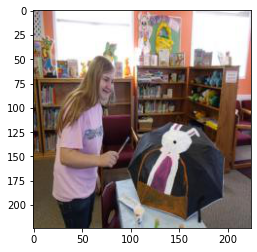

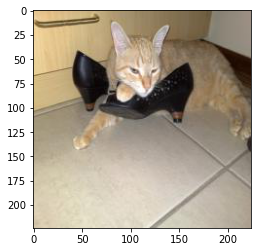

(None, None)

In [4]:
show_image(image1), show_image(image2)

## ResNet Feature Vectors

Each image has 1000 features provided extracted from the penultimate layer of the pretrained ResNet neural network.

In [5]:
def get_feat_matrix(train_set=True):
    """Get feature matrix for given dataset
    
    Parameters
    ----------
    train_set: bool (default=True)
        Whether to look in the train or in the test set.
        
    Returns
    -------
    X: ndarray of shape (n, 1000)
        A matrix containing the ResNet features for the train or test images.
    """
    if train_set:
        dataset = 'train'
    else:
        dataset = 'test'
    feats = pd.read_csv(
        os.path.join(DATA_DIR, f'features_{dataset}/features_resnet1000_{dataset}.csv'),
        names = ['Image']+["X{}".format(i) for i in range(1000)])
    # Need to sort data
    feats["Image"] = feats["Image"].apply(lambda s: int(s.split("/")[1].split(".jpg")[0]))
    feats.sort_values(by="Image", inplace=True)
    X = feats.values[:, 1:]
    return X

## Descriptions 

Each image comes with a series of human given queries (descriptions).

In [6]:
def get_description(image_index, train_set=True):
    """Get description of image with given index.
    
    Parameters
    ----------
    image_index: int
        Numeric index of the image (max 9999 for train, max 1999 for test).
    train_set: bool (default=True)
        Whether to look in the train or in the test set.
        
    Returns
    -------
    description: string
        The description of the image as a paragraph of text with punctuation removed.
    """
    if train_set:
        dataset = 'train'
    else:
        dataset = 'test'
    f = open(
        os.path.join(DATA_DIR, f'descriptions_{dataset}/{image_index}.txt'))
    desc = f.read()
    f.close()
    # Some post-processing 
    desc = desc.replace(".", " ")
    desc = desc.replace("\n", " ")
    return desc

In [7]:
get_description(image2)

'A strawberry blond cat is cuddled up between a pair of ladies business shoes   A cat resting on the floor cuddled up with a pair of heels Orange and white cat laying with its head on some shoes  A very cute orange cat laying with some shoes  a cat rests its head and paw on a pair of womens shoes '

In [8]:
# Download files
import urllib.request
import os

if not os.path.exists("GoogleNews-vectors-negative300.bin.gz"):
    urllib.request.urlretrieve("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", filename="GoogleNews-vectors-negative300.bin.gz")

In [9]:
import gensim

word2vec = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
print("Loaded word vectors successfully!")

Loaded word vectors successfully!


In [10]:
train_desc = [get_description(i) for i in range(10000)]
test_desc = [get_description(i, train_set=False) for i in range(2000)]

In [11]:
def doc_to_vec(sentence, word2vec):
    """Convert text to a 300-dimensional vector
    
    Each word is converted to a vector via the word-to-vec model and the vectors are averaged
    to give the final result.
    
    Parameters
    ----------
    sentence: string
        Text to be converted to a vector.
    word2vec: word2vec model
        Movel to be used for vectorization.
        
    Returns
    -------
    vec: array of shape (300, )
        Vector that represents the average of word2vec-transformed vectors for the given sentence. 
    """
    word_vecs = [word2vec.get_vector(w.lower()) for w in sentence.split() if w.lower() in word2vec.key_to_index]
    # Return average
    return np.stack(word_vecs).mean(0)

In [12]:
X = np.array([doc_to_vec(s, word2vec) for s in train_desc])
X_test = np.array([doc_to_vec(s, word2vec) for s in test_desc])

In [13]:
print("Shape of X:", X.shape)
print("Shape of X_test:", X_test.shape)
print("Done building features!")

Shape of X: (10000, 300)
Shape of X_test: (2000, 300)
Done building features!


In [14]:
Y = get_feat_matrix()
Y_test = get_feat_matrix(train_set=False)

In [15]:
print("Shape of Y:", Y.shape)
print("Shape of Y_test:", Y_test.shape)
print("Done building features!")

Shape of Y: (10000, 1000)
Shape of Y_test: (2000, 1000)
Done building features!


In [16]:
# Split training data for CV
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=2000, random_state=12345)

In [17]:
from sklearn.linear_model import Ridge #best
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVC

# image2sentence = BaggingRegressor(Ridge(alpha=40), n_estimators=100, n_jobs=-1).fit(Y,X)
image2sentence = Ridge(alpha=40).fit(Y,X)

In [24]:
from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity

combined_pics = np.concatenate((Y, Y_test), axis=0)
predicted_sentences = image2sentence.predict(combined_pics)

In [56]:
def getTopImages(sentence):
    sentence_vector = doc_to_vec(sentence.lower(), word2vec)
    pw_cosine = cosine_similarity(sentence_vector.reshape(1,-1), predicted_sentences).flatten()
    top10 = np.argsort(pw_cosine)[::-1][:10]
    fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
    for i, ax in enumerate(axs.flatten()):
        plt.sca(ax)
        if top10[i] >= 10000:
            show_image(top10[i]-10000, train_set=False)
        else:
            show_image(top10[i], train_set=True)

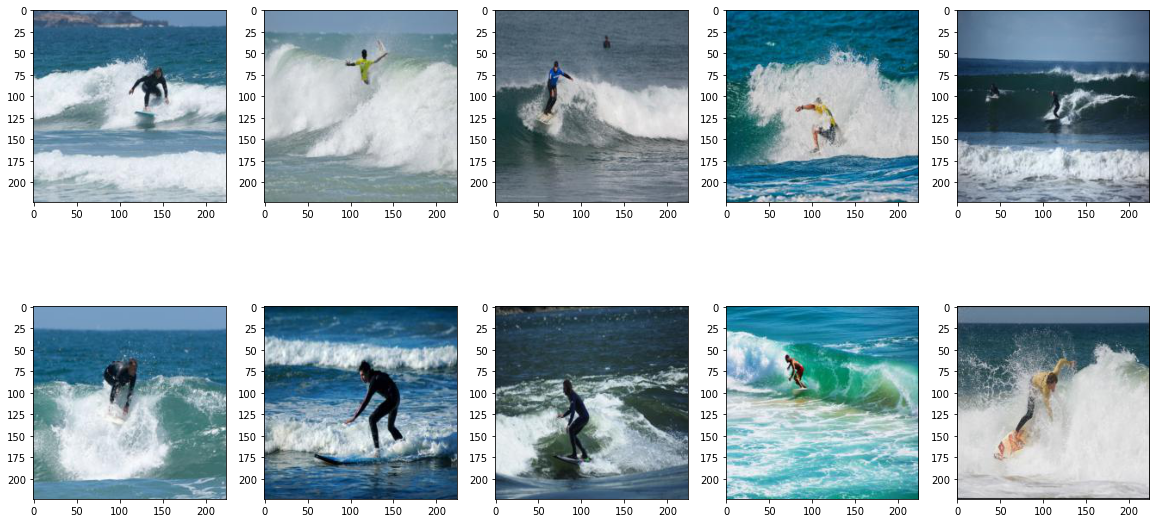

In [73]:
getTopImages('surfing')